In [13]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import warnings

plt.rcParams['font.family'] = 'Malgun Gothic'
warnings.filterwarnings('ignore')

In [18]:
train_df = pd.read_csv('./data/train.tsv', sep='\t')
test_df = pd.read_csv('./data/test.tsv', sep='\t')
print('shpae of train data: ', train_df.shape)
print('shpae of test data: ', test_df.shape)

shpae of train data:  (26099, 20)
shpae of test data:  (6525, 20)


In [15]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [16]:
train_df.dtypes

작성월           object
지역코드           int64
지역명           object
상권코드           int64
상권명           object
총건물수         float64
1층생활시설수      float64
2층생활시설수      float64
문화집회시설수      float64
종교시설수        float64
판매시설수        float64
의료시설수        float64
아동노인복지시설수    float64
수련시설수        float64
운동시설수        float64
숙박시설수        float64
여가및오락시설수     float64
총가스사용량         int64
상업용가스사용량       int64
총전기사용량       float64
month          int64
year           int64
dtype: object

In [5]:
print('shpae of train data: ', train_df.shape)
print('shpae of test data: ', test_df.shape)

shpae of train data:  (26096, 22)
shpae of test data:  (6525, 22)


In [6]:
feature_cols = [col for col in train_df.columns if col not in ["총전기사용량"]]

X = train_df[feature_cols].copy()
y = train_df["총전기사용량"].values.copy()

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
X_test = test_df.copy()
encoders = {}  # 각 컬럼별 encoder 저장

for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])


std_scalers = {}  # 각 컬럼별 encoder 저장
continous_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
for col in continous_features:
    std_train = StandardScaler()
    X[col] = std_train.fit_transform(X[[col]])
    std_scalers[col] = std_train
    X_test[col] = std_train.transform(X_test[[col]])
    
print('Shape of train X', X.shape)
print('Shape of test X', X_test.shape) # original index 포함되어있음.

Shape of train X (26096, 21)
Shape of test X (6525, 22)


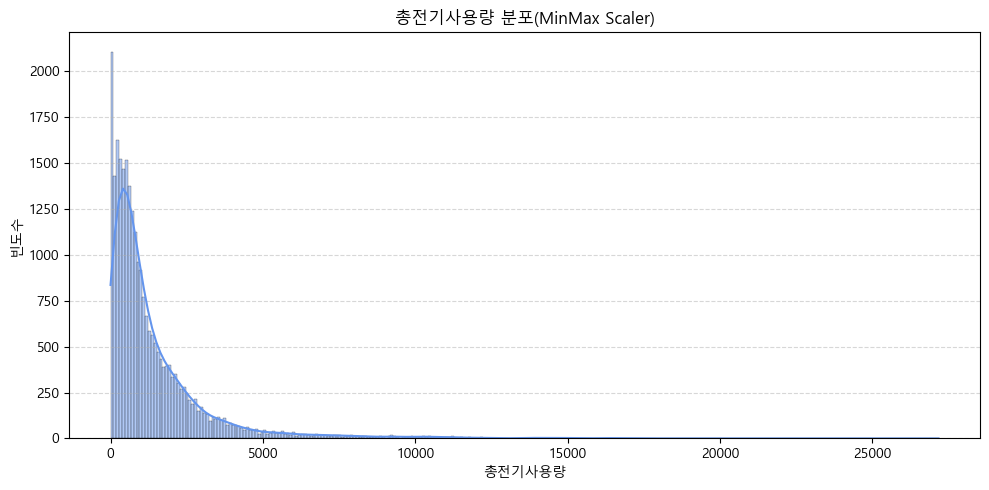

In [7]:

plt.figure(figsize=(10, 5))
sns.histplot(y, kde=True, color='cornflowerblue')
plt.title("총전기사용량 분포(MinMax Scaler)")
plt.xlabel("총전기사용량")
plt.ylabel("빈도수")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = [] 


rmse_scores = []
mse_scores = []
mae_scores = []
r2_scores = []


for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    print('-'*40)
    print(f'Fold {fold + 1}-th XGBoost model training...')
    
    # XGBoost
    #model = xgb.XGBRegressor(
    #    tree_method='gpu_hist', 
    #    gpu_id=0,
    #    random_state=42
    #)
    model = xgb.XGBRegressor(n_estimators=100)

    # training and validation mornitoring
    model.fit(X_train, y_train)
    models.append(model)
    
    y_val_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_val_pred)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print('-'*40)
    
    rmse_scores.append(rmse)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    
print(f"K-Fold mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"K-Fold mean MSE: {np.mean(mse_scores):.4f}")
print(f"K-Fold mean MAE: {np.mean(mae_scores):.4f}")
print(f"K-Fold mean R2: {np.mean(r2_scores):.4f}")



----------------------------------------
Fold 1-th XGBoost model training...
RMSE: 509.6278
MSE: 259720.5271
MAE: 236.2806
R2 Score: 0.9443
----------------------------------------
----------------------------------------
Fold 2-th XGBoost model training...
RMSE: 429.8781
MSE: 184795.1982
MAE: 222.0667
R2 Score: 0.9515
----------------------------------------
----------------------------------------
Fold 3-th XGBoost model training...
RMSE: 461.6505
MSE: 213121.1546
MAE: 230.4395
R2 Score: 0.9562
----------------------------------------
----------------------------------------
Fold 4-th XGBoost model training...
RMSE: 473.9164
MSE: 224596.7297
MAE: 237.5612
R2 Score: 0.9366
----------------------------------------
----------------------------------------
Fold 5-th XGBoost model training...
RMSE: 397.7657
MSE: 158217.5416
MAE: 229.5951
R2 Score: 0.9623
----------------------------------------
K-Fold mean RMSE: 454.5677
K-Fold mean MSE: 208090.2303
K-Fold mean MAE: 231.1886
K-Fold mean R

### 제출 파일 음수 값?? + original index 변환

In [9]:
original_index = X_test['index_origin']
X_test = X_test.drop(columns=['index_origin'])

In [10]:
y_preds = np.zeros((len(X_test), len(models)))

for i, model in enumerate(models):    
    predicted_value = model.predict(X_test)
    #inverse_predicted_value = minmax_target.inverse_transform(predicted_value.reshape(-1, 1))
    y_preds[:, i] = predicted_value

y_preds = y_preds.mean(axis=1)
mean_preds_df = pd.DataFrame(y_preds, columns=["y_pred"])

# 원래의 test set index 번호를 오름차순으로 정렬하여, 데이터 순서를 맞춰줌.
mean_preds_df['original_index'] = original_index.values
mean_preds_df = mean_preds_df.sort_values(by='original_index', ascending=True).reset_index(drop=True)
mean_preds_df = mean_preds_df.drop(columns=['original_index'])
mean_preds_df

,y_pred
0,850.267883
1,91.564311
2,2032.332666
3,719.511914
4,697.017529
...,...
6520,2040.429761
6521,584.397205
6522,1089.586743
6523,154.825697


In [11]:
mean_preds_df.to_csv('./results/baseline_submission(k5fold-xgboost).csv', sep=',', index=False)

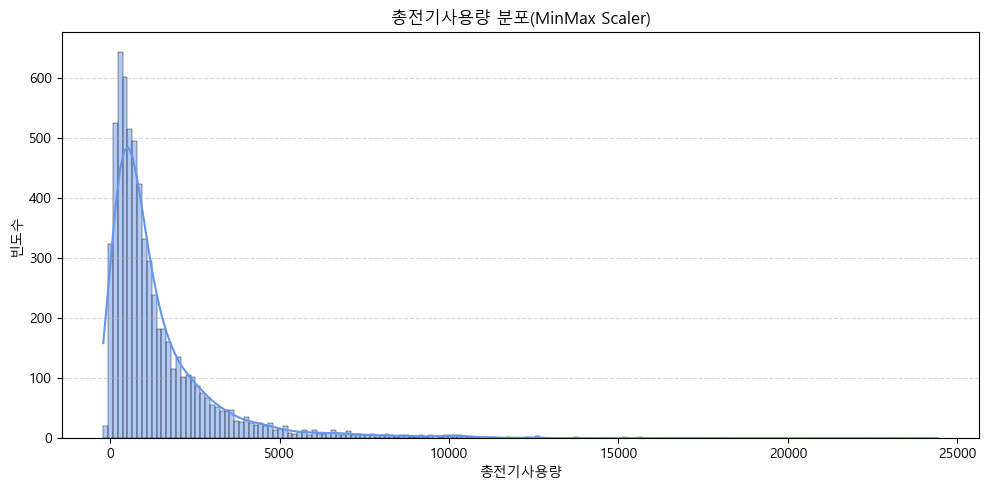